<a href="https://colab.research.google.com/github/JulianSilva2001/Image-Fitting/blob/main/Stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


descriptors1 [[  2. 127. 164. ...  67.   6.   0.]
 [  0.   1. 111. ...  20.   6.   0.]
 [  0.   0.   0. ...   0.   0.   1.]
 ...
 [  0.   1.   8. ...   0.   0.   0.]
 [  2. 105.  30. ...   3.   0.   0.]
 [  1.   0.   0. ...   0.   0.   2.]]
descriptors5 [[ 0.  0.  0. ...  0.  0.  2.]
 [48.  3.  4. ...  0.  0.  0.]
 [13.  4.  3. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  2.  5. ... 16.  0.  0.]
 [ 0.  0.  0. ...  2.  0.  0.]]


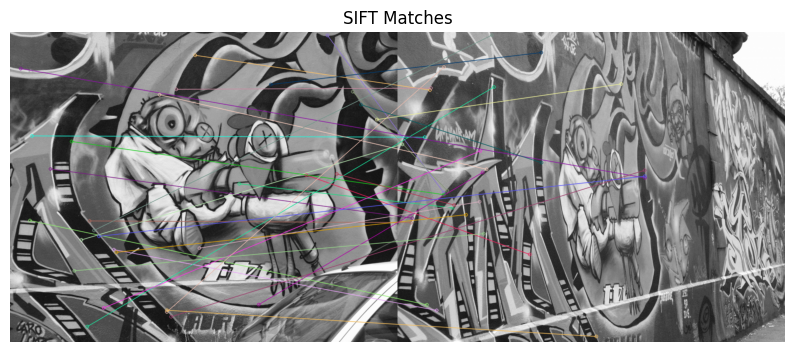

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv.imread('/content/drive/MyDrive/Image Fitting/graf/graf/img1.ppm', cv.IMREAD_GRAYSCALE)  # Graffiti image to be stitched
img5 = cv.imread('/content/drive/MyDrive/Image Fitting/graf/graf/img5.ppm', cv.IMREAD_GRAYSCALE)  # Base image

# Initialize SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

print("descriptors1",descriptors1)
print("descriptors5",descriptors5)

# Create a matcher and find matches
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors5)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)


# Draw the matches
img_matches = cv.drawMatches(img1, keypoints1, img5, keypoints5, matches[:30], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title('SIFT Matches')
plt.axis('off')
plt.show()


In [5]:
keypoints_train_image = np.float32([keypoint.pt for keypoint in keypoints5])
keypoints_query_image = np.float32([keypoint.pt for keypoint in keypoints1])

if len(matches) >= 4:
  points_train = np.float32([keypoints_query_image[m.queryIdx] for m in matches])
  points_query = np.float32([keypoints_train_image[m.trainIdx] for m in matches])

  H, status = cv.findHomography(points_train, points_query, cv.RANSAC)
else:
  print(f"Minimum match count not satisfied cannot get homopgrahy")

print(H)


[[ 1.47776438e-01 -6.40789291e-01  3.17218015e+02]
 [ 4.99254228e-02 -8.02970464e-01  4.30577990e+02]
 [ 1.31814533e-06 -1.80706820e-03  1.00000000e+00]]


In [54]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute the initial homography using RANSAC to detect inliers
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

# mask contains 1 for inliers, 0 for outliers
# Filter inlier points
inliers_src_pts = src_pts[mask.ravel() == 1]
inliers_dst_pts = dst_pts[mask.ravel() == 1]

# Recompute homography using all inliers (no random selection)
homography, _ = cv.findHomography(inliers_src_pts, inliers_dst_pts, 0)

print("Homography matrix calculated using inliers:\n", H_inliers)

Homography matrix calculated using inliers:
 [[ 1.47776438e-01 -6.40789291e-01  3.17218015e+02]
 [ 4.99254228e-02 -8.02970464e-01  4.30577990e+02]
 [ 1.31814533e-06 -1.80706820e-03  1.00000000e+00]]


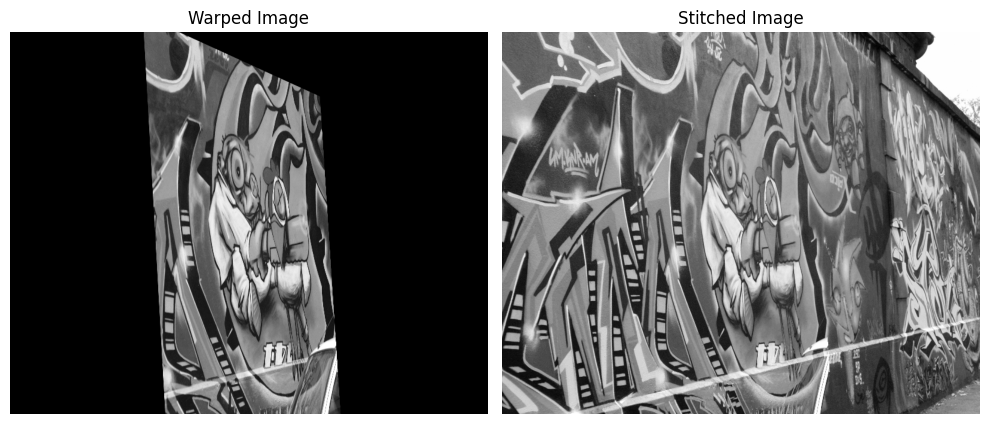

In [8]:
# Warp img1 to img5's perspective using the computed homography

H = np.array([
    [6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
    [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
    [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]
])
height, width = img5.shape
warped_img1 = cv.warpPerspective(img1, H, (width, height))



# Create a stitched image
stitched_img = np.maximum(warped_img1, img5)  # Simple blend

# Create a figure with specified size
plt.figure(figsize=(10, 10))

# Display the stitched image in the first subplot
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.imshow(stitched_img, cmap='gray')
plt.title('Stitched Image')
plt.axis('off')  # Hide the axes

# Display the warped image in the second subplot
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(warped_img1, cmap='gray')
plt.title('Warped Image')
plt.axis('off')  # Hide the axes

# Show the figure
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()